# Lab session 1: Dimensionality Reduction using Gaussian Processes

Gaussian Process Winter School, 14th September 2015
written by Max Zwiessele, Neil Lawrence

This lab session will focus on three aspects of GPs: sampling, the design of Experiments and uncertainty propagation.

## 1 Getting Started and Downloading Data

As for the last two lab sessions, the first thing to do is set the plots to appear inline and import relevant modules for the lab session.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
import string

The following code is for plotting and to prepare the bigger models for later useage. If you are interested, you can have a look, but this is not essential.

In [22]:
import matplotlib.pylab as pb
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]
def plot_model(X, which_dims, labels):
    fig = pb.figure(); ax = fig.add_subplot(111)
    X = X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass

For this lab, we've created a dataset `digits.npy` containing all handwritten digits from $0 \cdots 9$ handwritten, provided by deCampos et al. [2009]. We will only use some of the digits for the demonstrations in this lab class, but you can edit the code below to select different subsets of the digit data as you wish.

In [28]:
which = [0,1,2,6,7,9] # which digits to work on
data = GPy.util.datasets.decampos_digits(which_digits=which)
Y = data['Y']
labels = data['str_lbls']

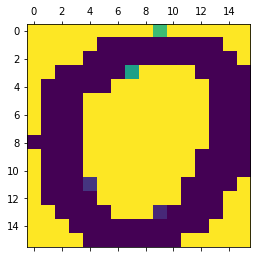

In [51]:
pb.matshow(data['Y'][0,0:16*16].reshape(16,16))

You can try to plot some of the digits using `pb.matshow` (the digit images have size `16x16`).

## 2 Principal Component Analysis

Principal component analysis (PCA) finds a rotation of the observed outputs, such that the rotated principal component (PC) space maximizes the variance of the data observed, sorted from most to least important (most to least variable in the corresponding PC).

In order to apply PCA in an easy way, we have included a PCA module in pca.py. You can import the module by 
import <path.to.pca> (without the ending .py!). 
To run PCA on the digits we have to reshape (Hint: np.reshape ) digits . 

* What is the right shape $n \times d$ to use?

We will call the reshaped observed outputs $\mathbf{Y}$ in the following.

In [27]:
Y.shape

(330, 256)

In [37]:
Yn = Y#-Y.mean()

Now let’s run PCA on the reshaped dataset $\mathbf{Y}$:

In [38]:
from GPy.util import pca
p = pca.PCA(Y) # create PCA class with digits dataset

The resulting plot will show the lower dimensional representation of the digits in 2 dimensions.

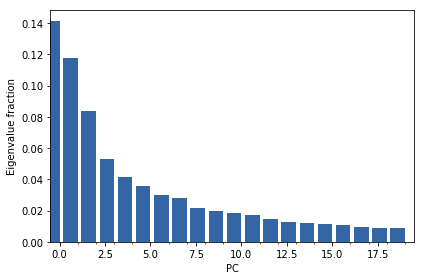

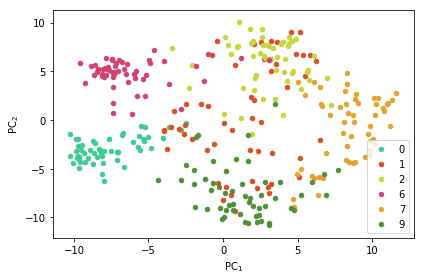

In [79]:
p.plot_fracs(20) # plot first 20 eigenvalue fractions
p.plot_2d(Y, labels=labels.flatten(), colors=colors)
plt.legend()

## 3 Gaussian Process Latent Variable Model

The Gaussian Process Latent Variable Model (GP-LVM) embeds of PCA into a Gaussian process framework, where the latent inputs $\mathbf{X}$ are learnt as hyperparameters and the mapping variables $\mathbf{W}$ are integrated out. The advantage of this interpretation is it allows PCA to be generalized in a non linear way by replacing the resulting *linear* covariance witha  non linear covariance. But first, let's see how GPLVM is equivalent to PCA using an automatic relevance determination (ARD, see e.g. Bishop et al. [2006]) linear kernel:

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0007   9.013439e+04   9.472590e+06 
    00s13  0013   4.382543e+04   7.377609e+07 
    00s16  0016   3.756584e+04   8.921558e+05 
    00s19  0019   3.624717e+04   7.587598e+06 
    01s20  0149   3.320983e+04   9.790406e+01 
    02s05  0264   3.320909e+04   1.576025e-01 
Runtime:     02s05
Optimization status: Converged



 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


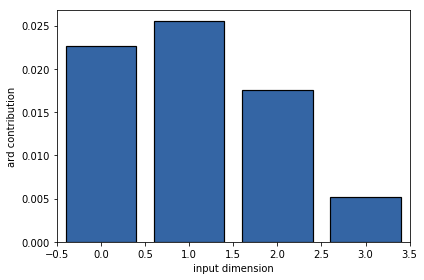

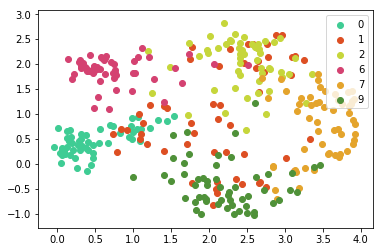

In [95]:
input_dim = 4 # How many latent dimensions to use
kernel = GPy.kern.Linear(input_dim, ARD=True) # ARD kernel
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

m.optimize(messages=1, max_iters=1000) # optimize for 1000 iterations
m.kern.plot_ARD()
plot_model(m.X, m.linear.variances.argsort()[-2:], labels.flatten())
pb.legend()

As you can see the solution with a linear kernel is the same as the PCA solution with the exception of rotational changes and axis flips.

For the sake of time, the solution you see was only running for 1000 iterations, thus it might not be converged fully yet. The GP-LVM proceeds by iterative optimization of the *inputs* to the covariance. As we saw in the lecture earlier, for the linear covariance, these latent points can be optimized with an eigenvalue problem, but generally, for non-linear covariance functions, we are obliged to use gradient based optimization.

### Exercise 1

a) How do your linear solutions differ between PCA and GPLVM with a linear kernel? Look at the plots and also try and consider how the linear ARD parameters compare to the eigenvalues of the principal components.

b) The next step is to use a non-linear mapping between inputs $\mathbf{X}$ and ouputs $\mathbf{Y}$ by selecting the exponentiated quadratic (`GPy.kern.rbf`) covariance function. 

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0008   2.498492e+04   4.022498e+06 
    00s15  0011   2.220180e+04   6.812799e+06 
    02s16  0197   1.338996e+04   2.152488e+03 
    08s20  0774   1.322634e+04   3.010374e+03 
    10s59  1002   1.322450e+04   2.665718e+00 
Runtime:     10s59
Optimization status: Maximum number of f evaluations reached



 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


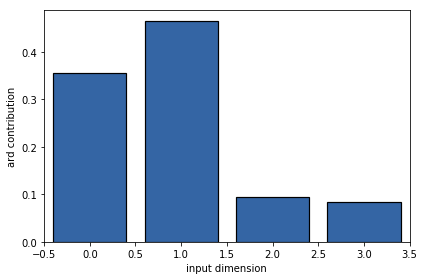

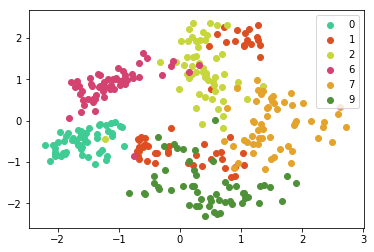

In [103]:
# Exercise 1 b) answer
input_dim = 4 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, ARD=True) # ARD kernel
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

m.optimize(messages=1, max_iters=1000) # optimize for 1000 iterations
m.kern.plot_ARD()
plot_model(m.X, m.rbf.input_sensitivity().argsort()[-2:], labels.flatten())
pb.legend()

c) How does the nonlinear model differe from the linear model? Are there digits that the GPLVM with an exponentiated quadratic covariance can separate, which PCA is not able to?

d) Try modifying the covariance function and running the model again. For example you could try a combination of the linear and exponentiated quadratic covariance function or the Matern 5/2. If you run into stability problems try initializing the covariance function parameters differently.

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0006   3.011550e+04   1.099168e+08 
    00s17  0007   3.944126e+04   4.951958e+08 
    01s18  0058   1.017885e+04   2.783701e+05 
    05s21  0301   9.534232e+03   2.665810e+03 
    08s23  0482   9.479350e+03   5.724150e+03 
    16s85  1002   9.394502e+03   4.661794e+02 
Runtime:     16s85
Optimization status: Maximum number of f evaluations reached



 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


AttributeError: 'GPLVM' object has no attribute 'rbf'

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


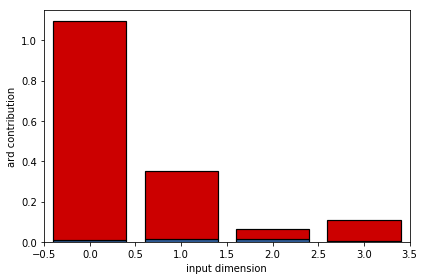

In [104]:
# Exercise 1 d) answer
input_dim = 4 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Matern52(input_dim, ARD=True) # ARD kernel
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

m.optimize(messages=1, max_iters=1000) # optimize for 1000 iterations
m.kern.plot_ARD()

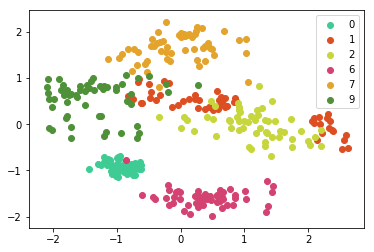

In [106]:
plot_model(m.X, m.sum.input_sensitivity().argsort()[-2:], labels.flatten())
pb.legend()

## 4 Bayesian GPLVM

In GP-LVM we use a point estimate of the distribution of the input $\mathbf{X}$. This estimate is derived through maximum likelihood or through a maximum a posteriori (MAP) approach. Ideally, we would like to also estimate a distribution over the input $\mathbf{X}$. In the Bayesian GPLVM we approximate the true distribution $p(\mathbf{X}|\mathbf{Y})$ by a variational approximation $q(\mathbf{X})$ and integrate $\mathbf{X}$ out. 

Approximating the posterior in this way allows us to optimize a lower bound on the marginal likelihood. Handling the uncertainty in a principled way allows the model to make an assessment of whether a particular latent dimension is required, or the variation is better explained by noise. This allows the algorithm to switch off latent dimensions. The switching off can take some time though, so below in Section 6 we provide a pre-learnt module, but to complete section 6 you'll need to be working in the IPython console instead of the notebook.

For the moment we'll run a short experiment applying the Bayesian GP-LVM with an exponentiated quadratic covariance function.

In [107]:
# Model optimization
input_dim = 5 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Yn, input_dim=input_dim, kernel=kern, num_inducing=25)

# initialize noise as 1% of variance in data
#m.likelihood.variance = m.Y.var()/100.
m.optimize(messages=1)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0004   4.006777e+04   7.651685e+07 
    00s15  0009   3.097741e+04   3.718663e+06 
    00s19  0011   2.967791e+04   2.856607e+05 
    01s19  0111   2.328650e+04   5.333021e+04 
    05s20  0515   2.251976e+04   6.178830e+03 
    06s20  0607   2.251318e+04   1.851072e+03 
    10s48  1002   2.250210e+04   2.997357e+01 
Runtime:     10s48
Optimization status: Maximum number of f evaluations reached



 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


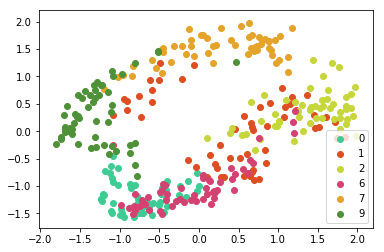

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


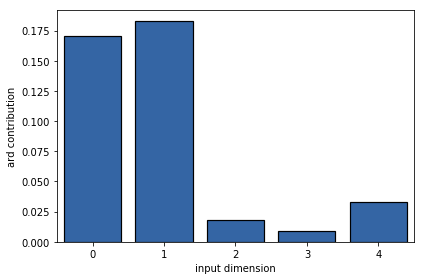

In [108]:
# Plotting the model
plot_model(m.X.mean, m.rbf.lengthscale.argsort()[:2], labels.flatten())
pb.legend()
m.kern.plot_ARD()
# Saving the model:
m.pickle('digit_bgplvm_rbf.pickle')

Because we are now also considering the uncertainty in the model, this optimization can take some time. However, you are free to interrupt the optimization at any point selecting `Kernel->Interupt` from the notepad menu. This will leave you with the model, `m` in the current state and you can plot and look into the model parameters. 

### Exercise 2

a) How does the Bayesian GP-LVM compare with the standard model?

### Preoptimized Model

A good way of working with latent variable models is to interact with the latent dimensions, generating data. This is a little bit tricky in the notebook, so below in section 6 we provide code for setting up an interactive demo in the standard IPython shell. If you are working on your own machine you can try this now. Otherwise continue with section 5.

## 5 Multiview Learning: Manifold Relevance Determination

In Manifold Relevance Determination we try to find one latent space, common for $K$ observed output sets (modalities) $\{\mathbf{Y}_{k}\}_{k=1}^{K}$. Each modality is associated with a separate set of ARD parameters so that it switches off different parts of the whole latent space and, therefore, $\mathbf{X}$ is softly segmented into parts that are private to some, or shared for all modalities. Can you explain what happens in the following example?

Again, you can stop the optimizer at any point and explore the result obtained with the so far training:

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0003   7.313429e+03   9.253003e+06 
    00s19  0006   4.959474e+03   3.609692e+04 
    01s20  0052   3.065614e+03   8.856465e+02 
    03s21  0167   2.988988e+03   1.610503e+01 
    05s24  0286   2.987814e+03   2.574875e-01 
    09s76  0540   2.987709e+03   5.489592e-02 
Runtime:     09s76
Optimization status: Converged



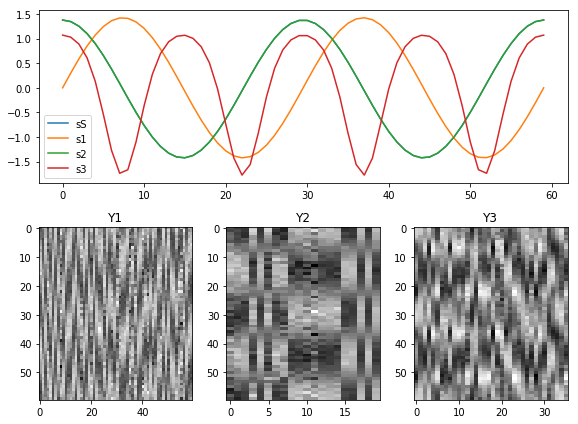

In [113]:
m = GPy.examples.dimensionality_reduction.mrd_simulation(optimize = False, plot=False)
m.optimize(messages = True, max_iters=3e3, optimizer = 'bfgs')

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


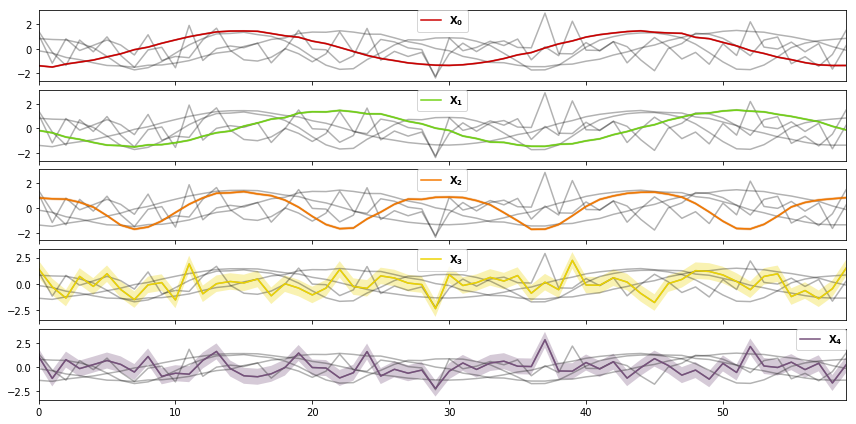

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


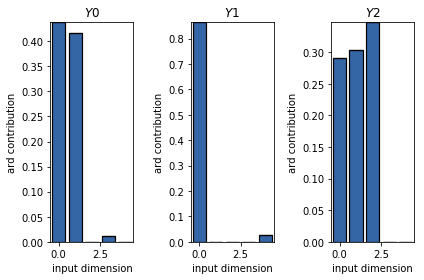

In [114]:
_ = m.X.plot()
m.plot_scales()

### Exercise 3

The simulated data set is a sinusoid and a double frequency sinusoid function as input signals.

a) Which signal is shared across the three datasets? 

b) Which are private? 

c) Are there signals shared only between two of the three datasets?

## 6 Interactive Demo: For Use Outside the Notepad

The module below loads a pre-optimized Bayesian GPLVM model (like the one you just trained) and allows you to interact with the latent space. 
Three interactive figures pop up: the latent space, the ARD scales and a sample in the output space (corresponding to the current selected latent point of the other figure). 
You can sample with the mouse from the latent space and obtain samples in the output space. 
You can select different latent dimensions to vary by clicking on the corresponding scales with the left and right mouse buttons.
This will also cause the latent space to be projected on the selected latent dimensions in the other figure.

In [112]:
from urllib.request import urlopen
import os, sys

model_path =  'digit_bgplvm_demo.pickle' # local name for model file
status = ""

re = 0
if len(sys.argv) == 2:
    re = 1

if re or not os.path.exists(model_path): # only download the model new, if it was not already
    url = 'http://staffwww.dcs.sheffield.ac.uk/people/M.Zwiessele/gpss/lab3/digit_bgplvm_demo.pickle'
    with open(model_path, 'wb') as f:
        u = urlopen(url)
        meta = u.info()
        file_size = int(meta.getheaders("Content-Length")[0])
        print("Downloading: %s" % (model_path))

        file_size_dl = 0
        block_sz = 8192
        while True:
            buff = u.read(block_sz)
            if not buff:
                break
            file_size_dl += len(buff)
            f.write(buff)
            sys.stdout.write(" "*(len(status)) + "\r")
            status = r"{:7.3f}/{:.3f}MB [{: >7.2%}]".format(file_size_dl/(1.*1e6), file_size/(1.*1e6), float(file_size_dl)/file_size)
            sys.stdout.write(status)
            sys.stdout.flush()
        sys.stdout.write(" "*(len(status)) + "\r")
        print(status)
else:
    print("Already cached, to reload run with 'reload' as the only argument")

HTTPError: HTTP Error 403: Forbidden

In [26]:
import cPickle as pickle
with open('./digit_bgplvm_demo.pickle', 'rb') as f:
    m = pickle.load(f)

Prepare for plotting of this model. If you run on a webserver the interactive plotting will not work. Thus, you can skip to the next codeblock and run it on your own machine, later.

In [26]:
fig = pb.figure('Latent Space & Scales', figsize=(16,6))
ax_latent = fig.add_subplot(121)
ax_scales = fig.add_subplot(122)

fig_out = pb.figure('Output', figsize=(1,1))
ax_image  = fig_out.add_subplot(111)
fig_out.tight_layout(pad=0)

data_show = GPy.plotting.matplot_dep.visualize.image_show(m.Y[0:1, :], dimensions=(16, 16), transpose=0, invert=0, scale=False, axes=ax_image)
#currently not available.
#lvm_visualizer = GPy.plotting.matplot_dep.visualize.lvm_dimselect(m.X.mean.copy(), m, data_show, ax_latent, ax_scales, labels=labels.flatten())

**Observations**

Confirm the following observations by interacting with the demo:

* We tend to obtain more "strange" outputs when sampling from latent space areas away from the training inputs.
* When sampling from the two dominant latent dimensions (the ones corresponding to large scales) we differentiate between all digits. Also note that projecting the latent space into the two dominant dimensions better separates the classes.
* When sampling from less dominant latent dimensions the outputs vary in a more subtle way.

You can also run the dimensionality reduction example

Optimizing model:


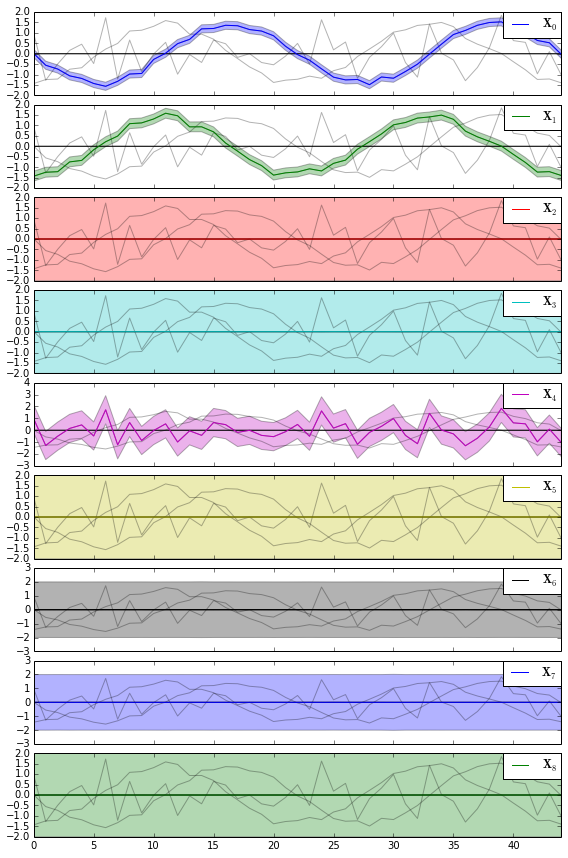

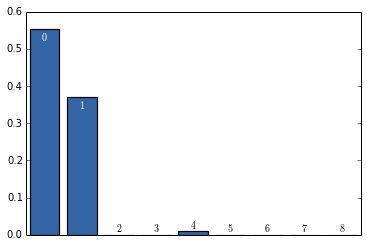

In [27]:
GPy.examples.dimensionality_reduction.bgplvm_simulation()

**Questions**

* Can you see a difference in the ARD parameters to the non Bayesian GPLVM?
* How does the Bayesian GPLVM allow the ARD parameters of the RBF kernel magnify the two first dimensions?
* Is Bayesian GPLVM better in differentiating between different kinds of digits?
* Why does the starting noise variance have to be lower then the variance of the observed values?
* How come we use the lowest variance when using a linear kernel, but the highest lengtscale when using an RBF kernel?

## References

C. M. Bishop. Pattern recognition and machine learning, volume 1. springer New York, 2006.

T. de Campos, B. R. Babu, and M. Varma. Character recognition in natural images. VISAPP 2009.

N. D. Lawrence. Probabilistic non-linear principal component analysis with Gaussian process latent variable models. In Journal of Machine Learning Research 6, pp 1783--1816, 2005